# LAB 8 : Autoencoders

Name : Girish Kumar Gupta

Roll Number : 211022002

Reference : 
 1. https://towardsdatascience.com/how-to-make-an-autoencoder-2f2d99cd5103
 2. https://www.geeksforgeeks.org/contractive-autoencoder-cae/
 3. https://blog.keras.io/building-autoencoders-in-keras.html

## Problem 1 :  Demonstrate the working principle of Autoencoder. (pytorch/keras/tensorflow)
Observation to be demonstrated
1. Use suitable data to demonstrate the same. (MNIST fashion/digit data can be
used)
2. Train the auto encoder with clean image and test using noisy image (you can add
some random Gaussian noise). Demonstrate the effect with/without dropout.
3. CNN with output Sigmoid layer and MSE loss can be used. Justify why Sigmoid is fine in this case.
4. Train the network with both clean and noisy version of image where the labeled
image is clean one (that given output to the autoencoder). Demonstrate output
of the autoencoder with noisy image (that is generated separately not used in
training).

### Write down the Objectives, Hypothesis and Experimental description for the above problem


## Programming : 
  Please write a program to demonstrate the same

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tensorflow 
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.layers import Conv2D, Flatten,MaxPool2D,UpSampling2D
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras import regularizers
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

## <a id="42">Loading Dataset</a>

In [2]:
(x_train, _), (x_test, _) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


### Reshaping datasets

In [3]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

### Adding noise to the dataset

In [4]:
noise_factor = 0.3 
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)


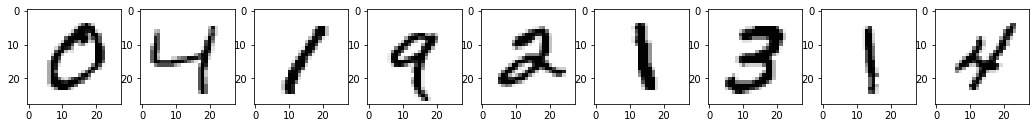

In [5]:
#Displaying images 
plt.figure(figsize=(20, 2))
for i in range(1,10):
    ax = plt.subplot(1, 10, i)
    plt.imshow(x_train[i].reshape(28, 28), cmap="binary")
plt.show()

### Sample from noisy dataset

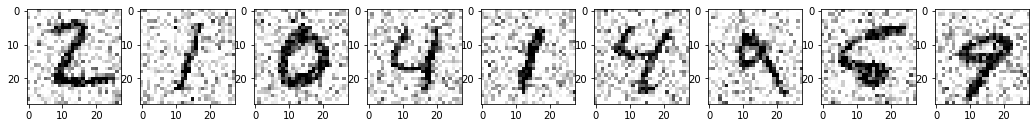

In [6]:
#Displaying images with noise
plt.figure(figsize=(20, 2))
for i in range(1,10):
    ax = plt.subplot(1, 10, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap="binary")
plt.show()

## <a id="42">Defininig Model</a>

### Without dropout

In [7]:
input_shape = (28, 28, 1)
batch_size = 64
kernel_size = 3
latent_dim = 16
# encoder/decoder number of CNN layers and filters per layer
layer_filters = [32, 64]

# build the autoencoder model
# first build the encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs

# stack of Conv2D(32)-Conv2D(64)
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)

# shape info needed to build decoder model so we don't do hand computation
# the input to the decoder's first Conv2DTranspose will have this shape
# shape is (7, 7, 64) which can be processed by the decoder back to (28, 28, 1)
shape = K.int_shape(x)

# generate the latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# instantiate encoder model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

# build the decoder model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
# use the shape (7, 7, 64) that was earlier saved
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
# from vector to suitable shape for transposed conv
x = Reshape((shape[1], shape[2], shape[3]))(x)

# stack of Conv2DTranspose(64)-Conv2DTranspose(32)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

# reconstruct the denoised input
outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          padding='same',
                          activation='sigmoid',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# autoencoder = encoder + decoder
# instantiate autoencoder model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

# Mean Square Error (MSE) loss function, Adam optimizer
autoencoder.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

# train the autoencoder
train_model=autoencoder.fit(x_train,
                x_train,
                validation_split=0.3,
                epochs=10,
                batch_size=batch_size)

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 latent_vector (Dense)       (None, 16)                50192     
                                                                 
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
______________________________________

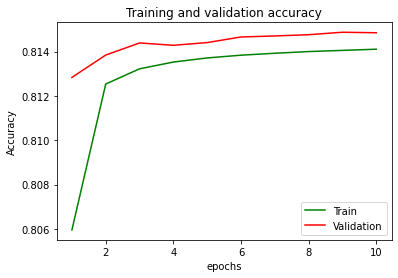

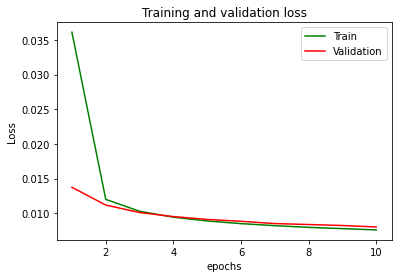

In [8]:
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = list(range(1,len(acc)+1))

    
    plt.plot(epochs,acc, c="Green", label='Train')
    plt.plot(epochs,val_acc, c="red", label='Validation')
    plt.xlabel('epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.show()

    
    plt.plot(epochs,loss, c="Green", label='Train')
    plt.plot(epochs,val_loss, c="red", label='Validation')
    plt.xlabel('epochs')
    plt.ylabel('Loss')
    plt.title('Training and validation loss')
    plt.legend()
    
    plt.show()

plot_accuracy_and_loss(train_model)

In [9]:
score = autoencoder.evaluate(x_test_noisy, x_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.03648078441619873
Test accuracy: 0.7992820143699646


### Predicting outpupts

(10000, 28, 28, 1)
(10000, 28, 28, 1)


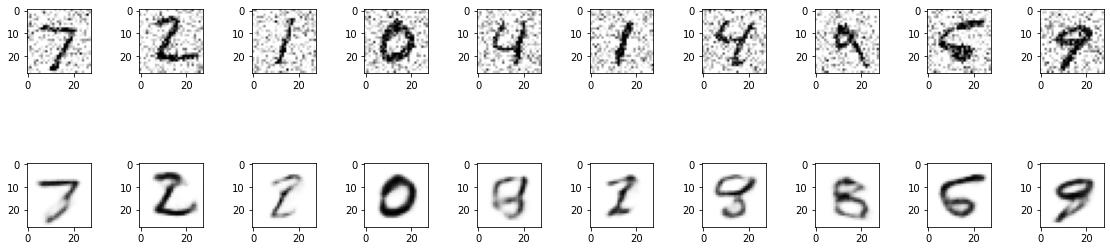

In [10]:
no_noise_img = autoencoder.predict(x_test_noisy)
print(no_noise_img.shape)
print(x_test_noisy.shape)
plt.figure(figsize=(40, 4))
for i in range(10):
    # display original
    ax = plt.subplot(3, 20, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap="binary")
    
    # display reconstructed (after noise removed) image
    ax = plt.subplot(3, 20, 40 +i+ 1)
    plt.imshow(no_noise_img[i].reshape(28, 28), cmap="binary")

plt.show()

### With dropout

In [11]:
input_shape = (28, 28, 1)
batch_size = 64
kernel_size = 3
latent_dim = 16
# encoder/decoder number of CNN layers and filters per layer
layer_filters = [32, 64]

# build the autoencoder model
# first build the encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs

# stack of Conv2D(32)-Conv2D(64)
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)
    x = Dropout(0.2)(x)

# shape info needed to build decoder model so we don't do hand computation
# the input to the decoder's first Conv2DTranspose will have this shape
# shape is (7, 7, 64) which can be processed by the decoder back to (28, 28, 1)
shape = K.int_shape(x)

# generate the latent vector
x = Flatten()(x)
x = Dropout(0.2)(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# instantiate encoder model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

# build the decoder model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
# use the shape (7, 7, 64) that was earlier saved
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
# from vector to suitable shape for transposed conv
x = Reshape((shape[1], shape[2], shape[3]))(x)
x = Dropout(0.2)(x)

# stack of Conv2DTranspose(64)-Conv2DTranspose(32)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)
    x = Dropout(0.2)(x)

# reconstruct the denoised input
outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          padding='same',
                          activation='sigmoid',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# autoencoder = encoder + decoder
# instantiate autoencoder model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

# Mean Square Error (MSE) loss function, Adam optimizer
autoencoder.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

# train the autoencoder
train_model=autoencoder.fit(x_train,
                x_train,
                validation_split=0.3,
                epochs=10,
                batch_size=batch_size)

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 32)        320       
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 flatten_1 (Flatten)         (None, 3136)              0         
                                                                 
 dropout_2 (Dropout)         (None, 3136)              0   

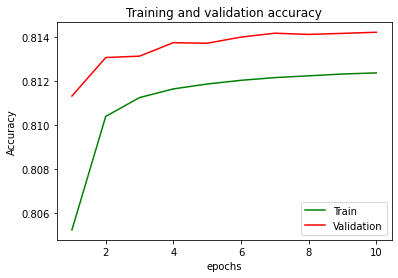

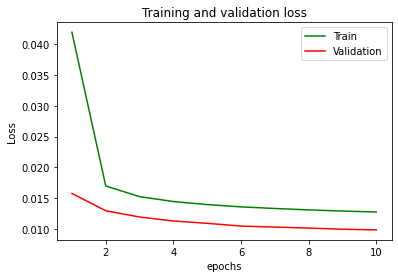

In [12]:
plot_accuracy_and_loss(train_model)

In [13]:
score = autoencoder.evaluate(x_test_noisy, x_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.02887999638915062
Test accuracy: 0.7982943654060364


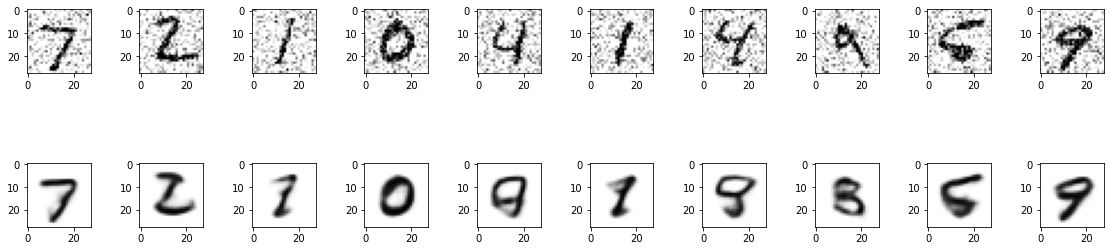

In [14]:
no_noise_img =autoencoder.predict(x_test_noisy)

plt.figure(figsize=(40, 4))
for i in range(10):
    # display original
    ax = plt.subplot(3, 20, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap="binary")
    
    # display reconstructed (after noise removed) image
    ax = plt.subplot(3, 20, 40 +i+ 1)
    plt.imshow(no_noise_img[i].reshape(28, 28), cmap="binary")

plt.show()

###### Inferences and Conclusion : State all the key observations and conclusion

The accuracy of model without dropout is 0.8126 and with dropout it is 0.8121.

## Problem 2 : Demonstrate the importance of different regularization techniques to train an Autoencoder. (pytorch/keras/tensorflow)

Observation to be demonstrated
1. Use suitable data and auto-encoder architecture to demonstrate the same. (MNIST
fashion/digit data can be used)
1. Implement weight decaying, sparse and contractive regularization functions and train the autoencoder using the same and show the significance of using
them in autoencoder training

##Write down the Objectives, Hypothesis and Experimental description for the above problem


## Programming : 
  Please write a program to demonstrate the same

## Model

In [15]:
# input_shape = (28, 28, 1)

# inputs = Input(shape=input_shape, name='encoder_input')
# x = Flatten()(inputs)
# x = Dense(64,activation='relu')(x)
# x = Dense(32,activation='relu')(x)
# x = Dense(16,activation='relu',name='encoded')(x)
# x = Dense(32,activation='relu')(x)
# x = Dense(64,activation='relu')(x)
# outputs = Dense(784,activation='sigmoid',name='decoded')(x)
# model = Model(inputs, outputs)

# model.summary()
encoder = Sequential()
encoder.add(Conv2D(filters=16, kernel_size=(4,4),input_shape=(28, 28,1),padding="same", activation='relu',))
encoder.add(MaxPool2D(pool_size=(2, 2)))

encoder.add(Conv2D(filters=32, kernel_size=(4,4),padding="same", activation='relu',))
encoder.summary()

decoder = Sequential()
decoder.add(Conv2D(filters=32, kernel_size=(4,4),input_shape=(14, 14,32),padding="same", activation='relu',))
decoder.add(UpSampling2D(size=(2,2)))
decoder.add(Conv2D(filters=1, kernel_size=(4,4),padding="same", activation='sigmoid',))
decoder.summary()

autoencoder = Sequential([encoder, decoder])
autoencoder.compile(loss="mse",optimizer='adam',metrics=['accuracy'])
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 16)        272       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 32)        8224      
                                                                 
Total params: 8,496
Trainable params: 8,496
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 14, 14, 32)        16416     
                                

In [16]:
# model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
# x_train_reshaped = x_train.reshape(len(x_train),784)
# x_test_reshaped = x_test.reshape(len(x_test),784)
# print(x_train_reshaped.shape)
# # train the autoencoder
# train_model=model.fit(x_train,
#                 x_train_reshaped,
#                 validation_data=(x_test_noisy, x_test_reshaped),
#                 epochs=100,
#                 batch_size=batch_size)
### Training the autoencoder
simple_autoencoder = autoencoder.fit(x_train, x_train, batch_size = 256, epochs=20,validation_split=0.3)

Epoch 1/20
165/165 [==============================] - 6s 31ms/step - loss: 0.0356 - accuracy: 0.8056 - val_loss: 0.0040 - val_accuracy: 0.8159
Epoch 2/20
165/165 [==============================] - 5s 29ms/step - loss: 0.0029 - accuracy: 0.8151 - val_loss: 0.0024 - val_accuracy: 0.8161
Epoch 3/20
165/165 [==============================] - 5s 33ms/step - loss: 0.0020 - accuracy: 0.8152 - val_loss: 0.0018 - val_accuracy: 0.8161
Epoch 4/20
165/165 [==============================] - 5s 29ms/step - loss: 0.0016 - accuracy: 0.8152 - val_loss: 0.0015 - val_accuracy: 0.8161
Epoch 5/20
165/165 [==============================] - 5s 33ms/step - loss: 0.0014 - accuracy: 0.8152 - val_loss: 0.0014 - val_accuracy: 0.8161
Epoch 6/20
165/165 [==============================] - 5s 33ms/step - loss: 0.0013 - accuracy: 0.8152 - val_loss: 0.0012 - val_accuracy: 0.8161
Epoch 7/20
165/165 [==============================] - 5s 29ms/step - loss: 0.0012 - accuracy: 0.8152 - val_loss: 0.0011 - val_accuracy: 0.8161

In [17]:
score = autoencoder.evaluate(x_test_noisy, x_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.02630305103957653
Test accuracy: 0.8001654148101807


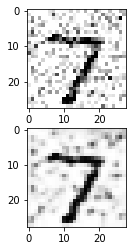

In [18]:
pred = autoencoder.predict(x_test_noisy)
# display original
plt.subplot(2, 1, 1)
plt.imshow(x_test_noisy[0].reshape(28, 28), cmap="binary")

# display reconstructed (after noise removed) image
ax = plt.subplot(2, 1, 2)
plt.imshow(pred[0].reshape(28, 28), cmap="binary")

### Sparse autoencoder

* Sparse autoencoders have hidden nodes greater than input nodes. They can still discover important features from the data.
* Sparsity constraint is introduced on the hidden layer. This is to prevent output layer copy input data.
* Sparse autoencoders have a sparsity penalty, Ω(h), a value close to zero but not zero. Sparsity penalty is applied on the hidden layer in addition to the reconstruction error. This prevents overfitting.

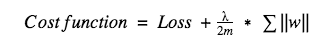

* This is equivalent to L1 regulirizer.


In [19]:
# input_shape = (28, 28, 1)

# inputs = Input(shape=input_shape, name='encoder_input')
# x = Flatten()(inputs)
# x = Dense(64,activation='relu',activity_regularizer=regularizers.l1(10e-5))(x)
# x = Dense(32,activation='relu',activity_regularizer=regularizers.l1(10e-5))(x)
# x = Dense(16,activation='relu',name='encoded',activity_regularizer=regularizers.l1(10e-5))(x)
# x = Dense(32,activation='relu',activity_regularizer=regularizers.l1(10e-5))(x)
# x = Dense(64,activation='relu',activity_regularizer=regularizers.l1(10e-5))(x)
# outputs = Dense(784,activation='sigmoid',name='decoded')(x)
# model = Model(inputs, outputs)

# model.summary()
sparseRegularizer=regularizers.l1(0.0001)
sparseEncoder = Sequential()
sparseEncoder.add(Conv2D(filters=16, kernel_size=(4,4),input_shape=(28, 28,1),padding="same", activation='sigmoid',activity_regularizer=sparseRegularizer))
sparseEncoder.add(MaxPool2D(pool_size=(2, 2)))

sparseEncoder.add(Conv2D(filters=32, kernel_size=(4,4),padding="same", activation='sigmoid',activity_regularizer=sparseRegularizer))

sparseDecoder = Sequential()
sparseDecoder.add(Conv2D(filters=32, kernel_size=(4,4),input_shape=(14, 14,32),padding="same", activation='sigmoid',activity_regularizer=sparseRegularizer))
sparseDecoder.add(UpSampling2D(size=(2,2)))
sparseDecoder.add(Conv2D(filters=1, kernel_size=(4,4),padding="same", activation='sigmoid'))
sparseAutoencoder = Sequential([sparseEncoder, sparseDecoder])
sparseAutoencoder.compile(loss="mse",optimizer='adam',metrics=['accuracy'])


In [20]:
# model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
# x_train_reshaped = x_train.reshape(len(x_train),784)
# x_test_reshaped = x_test.reshape(len(x_test),784)
# print(x_train_reshaped.shape)
# # train the autoencoder
# train_model=model.fit(x_train,
#                 x_train_reshaped,
#                 validation_data=(x_test_noisy, x_test_reshaped),
#                 epochs=100,
#                 batch_size=batch_size)
sparseHistory = sparseAutoencoder.fit(x_train, x_train, batch_size = 100, epochs=20,validation_split=0.3)

Epoch 1/20
420/420 [==============================] - 8s 16ms/step - loss: 0.6691 - accuracy: 0.8086 - val_loss: 0.5013 - val_accuracy: 0.8094
Epoch 2/20
420/420 [==============================] - 7s 16ms/step - loss: 0.4308 - accuracy: 0.8069 - val_loss: 0.3732 - val_accuracy: 0.8062
Epoch 3/20
420/420 [==============================] - 6s 15ms/step - loss: 0.3297 - accuracy: 0.8053 - val_loss: 0.2907 - val_accuracy: 0.8060
Epoch 4/20
420/420 [==============================] - 7s 16ms/step - loss: 0.2595 - accuracy: 0.8064 - val_loss: 0.2305 - val_accuracy: 0.8088
Epoch 5/20
420/420 [==============================] - 7s 16ms/step - loss: 0.2072 - accuracy: 0.8085 - val_loss: 0.1858 - val_accuracy: 0.8097
Epoch 6/20
420/420 [==============================] - 6s 15ms/step - loss: 0.1687 - accuracy: 0.8092 - val_loss: 0.1527 - val_accuracy: 0.8102
Epoch 7/20
420/420 [==============================] - 7s 16ms/step - loss: 0.1397 - accuracy: 0.8097 - val_loss: 0.1276 - val_accuracy: 0.8107

In [21]:
score = sparseAutoencoder.evaluate(x_test_noisy, x_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.0974489152431488
Test accuracy: 0.7226935029029846


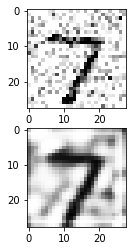

In [22]:
pred = sparseAutoencoder.predict(x_test_noisy)
# display original
plt.subplot(2, 1, 1)
plt.imshow(x_test_noisy[0].reshape(28, 28), cmap="binary")

# display reconstructed (after noise removed) image
ax = plt.subplot(2, 1, 2)
plt.imshow(pred[0].reshape(28, 28), cmap="binary")

### Weight Decay autoencoder


* Weight Decay constraint is introduced on the hidden layer. This is to prevent large weights.
* Weight Decay autoencoders have a sparsity penalty, Ω(h), a value close to zero but not zero. Weight Decay penalty is applied on the hidden layer in addition to the reconstruction error. This prevents overfitting.

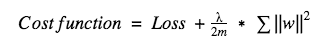

* This is equivalent to L2 regulirizer.


In [30]:
# input_shape = (28, 28, 1)

# inputs = Input(shape=input_shape, name='encoder_input')
# x = Flatten()(inputs)
# x = Dense(64,activation='relu',activity_regularizer=regularizers.l2(10e-5))(x)
# x = Dense(32,activation='relu',activity_regularizer=regularizers.l2(10e-5))(x)
# x = Dense(16,activation='relu',name='encoded',activity_regularizer=regularizers.l2(10e-5))(x)
# x = Dense(32,activation='relu',activity_regularizer=regularizers.l2(10e-5))(x)
# x = Dense(64,activation='relu',activity_regularizer=regularizers.l2(10e-5))(x)
# outputs = Dense(784,activation='relu',name='decoded')(x)
# model = Model(inputs, outputs)

# model.summary()

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
kernel_regularizer = tf.keras.regularizers.l2(l2=1e-3)

WDEncoder = Sequential()
WDEncoder.add(Conv2D(filters=16, kernel_size=(4,4),input_shape=(28, 28,1),padding="same", activation='relu',kernel_regularizer=kernel_regularizer))
WDEncoder.add(MaxPool2D(pool_size=(2, 2)))

WDEncoder.add(Conv2D(filters=32, kernel_size=(4,4),padding="same", activation='relu',kernel_regularizer=kernel_regularizer))

WDDecoder = Sequential()
WDDecoder.add(Conv2D(filters=32, kernel_size=(4,4),input_shape=(14, 14,32),padding="same", activation='relu',kernel_regularizer=kernel_regularizer))
WDDecoder.add(UpSampling2D(size=(2,2)))
WDDecoder.add(Conv2D(filters=1, kernel_size=(4,4),padding="same", activation='sigmoid',kernel_regularizer=kernel_regularizer))

WDAutoencoder = Sequential([WDEncoder, WDDecoder])
WDAutoencoder.compile(loss="mse",optimizer='adam',metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss',patience=3)


In [31]:
# model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
# x_train_reshaped = x_train.reshape(len(x_train),784)
# x_test_reshaped = x_test.reshape(len(x_test),784)
# print(x_train_reshaped.shape)
# # train the autoencoder
# train_model=model.fit(x_train,
#                 x_train_reshaped,
#                 validation_data=(x_test_noisy, x_test_reshaped),
#                 epochs=100,
#                 batch_size=batch_size)
decayhistory = WDAutoencoder.fit(x_train, x_train, batch_size = 128, epochs=20,validation_split=0.3)

Epoch 1/20
329/329 [==============================] - 8s 21ms/step - loss: 0.0397 - accuracy: 0.8119 - val_loss: 0.0141 - val_accuracy: 0.8159
Epoch 2/20
329/329 [==============================] - 6s 18ms/step - loss: 0.0123 - accuracy: 0.8150 - val_loss: 0.0124 - val_accuracy: 0.8160
Epoch 3/20
329/329 [==============================] - 6s 17ms/step - loss: 0.0111 - accuracy: 0.8151 - val_loss: 0.0108 - val_accuracy: 0.8160
Epoch 4/20
329/329 [==============================] - 6s 19ms/step - loss: 0.0106 - accuracy: 0.8151 - val_loss: 0.0105 - val_accuracy: 0.8160
Epoch 5/20
329/329 [==============================] - 6s 19ms/step - loss: 0.0105 - accuracy: 0.8151 - val_loss: 0.0105 - val_accuracy: 0.8160
Epoch 6/20
329/329 [==============================] - 6s 18ms/step - loss: 0.0103 - accuracy: 0.8151 - val_loss: 0.0103 - val_accuracy: 0.8160
Epoch 7/20
329/329 [==============================] - 6s 17ms/step - loss: 0.0103 - accuracy: 0.8151 - val_loss: 0.0104 - val_accuracy: 0.8160

In [32]:
score = WDAutoencoder.evaluate(x_test_noisy, x_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
# print(score)

Test loss: 0.01577548310160637
Test accuracy: 0.8139646649360657


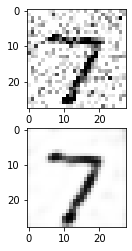

In [34]:
pred = WDAutoencoder.predict(x_test_noisy)
# display original
plt.subplot(2, 1, 1)
plt.imshow(x_test_noisy[0].reshape(28, 28), cmap="binary")

# display reconstructed (after noise removed) image
ax = plt.subplot(2, 1, 2)
plt.imshow(pred[0].reshape(28, 28), cmap="binary")

### Contractive Autoencoder


* A contractive autoencoder is considered an unsupervised deep learning technique. It helps a neural network to encode unlabeled training data. The idea behind that is to make the autoencoders robust small changes in the training dataset. 
* We use autoencoders to learn a representation, or encoding, for a set of unlabeled data. It is usually the first step towards dimensionality reduction or generating new data models. Contractive autoencoder targets to learn invariant representations to unimportant transformations for the given data.



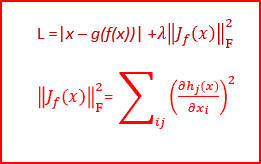

In [35]:
# input_shape = (28, 28, 1)

# inputs = Input(shape=input_shape, name='encoder_input')
# x = Flatten()(inputs)
# x = Dense(64,activation='relu')(x)
# x = Dense(32,activation='relu')(x)
# x = Dense(16,activation='relu',name='encoded')(x)
# x = Dense(32,activation='relu')(x)
# x = Dense(64,activation='relu')(x)
# outputs = Dense(784,activation='relu',name='decoded')(x)
# model = Model(inputs, outputs)

# model.summary()
contractiveEncoder = Sequential()
contractiveEncoder.add(Conv2D(filters=16,kernel_size=(4,4),input_shape=(28, 28,1),padding="same", activation='relu'))
contractiveEncoder.add(MaxPool2D(pool_size=(2, 2)))
contractiveEncoder.add(Conv2D(filters=32,kernel_size=(4,4),padding="same", activation='relu',))
contractiveEncoder.summary()

contractiveDecoder = Sequential()
contractiveDecoder.add(Conv2D(filters=32,kernel_size=(4,4),input_shape=(14, 14,32),padding="same", activation='relu',))
contractiveDecoder.add(UpSampling2D(size=(2,2)))
contractiveDecoder.add(Conv2D(filters=1,kernel_size=(4,4),padding="same", activation='sigmoid',))
contractiveDecoder.summary()
contractiveAutoencoder = Sequential([contractiveEncoder, contractiveDecoder])
contractiveAutoencoder.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 28, 28, 16)        272       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 conv2d_21 (Conv2D)          (None, 14, 14, 32)        8224      
                                                                 
Total params: 8,496
Trainable params: 8,496
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 14, 14, 32)        16416     
                            

In [36]:
def contractive_loss(y_pred, y_true):
    mse = K.mean(K.square(y_true - y_pred), axis=1)
    W = K.variable(value=model.get_layer('encoded').get_weights()[0])  
    W = K.transpose(W)
    h = model.get_layer('encoded').output
    dh = h * (1 - h)
    contractive = lam * K.sum(dh**2 * K.sum(W**2, axis=1), axis=1) #uses the last formula
    return mse + contractive #returns total loss calculated

In [37]:
# model.compile(loss=contractive_loss, optimizer='adam', metrics=['accuracy'])
# x_train_reshaped = x_train.reshape(len(x_train),784)
# x_test_reshaped = x_test.reshape(len(x_test),784)
# print(x_train_reshaped.shape)
# # train the autoencoder
# train_model=model.fit(x_train,
#                 x_train_reshaped,
#                 validation_data=(x_test_noisy, x_test_reshaped),
#                 epochs=100,
#                 batch_size=batch_size)
contractiveAutoencoder.compile(loss=contractive_loss,optimizer='adam',metrics=['accuracy'])
tf.get_logger().setLevel('ERROR')


In [39]:
# Prepare a dataset.
dataset = tf.data.Dataset.from_tensor_slices(
              (x_train[0:4000].astype("float32"), x_train[0:4000].astype("float32"))
)
dataset = dataset.shuffle(buffer_size=1024).batch(16)

# Instantiate a logistic loss function that expects integer targets.
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Instantiate an optimizer.
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Iterate over the batches of the dataset.
for epoch in range(30):
    for step, (x, y) in enumerate(dataset):

        # Open a GradientTape.
        with tf.GradientTape(persistent=True) as tape:
            with tf.GradientTape(persistent=True) as tape1:
                # Forward pass.
                logits = contractiveAutoencoder(x)
                hidden_representation = contractiveEncoder(x)
                
            jacobian = tape1.batch_jacobian(hidden_representation, x)
            jacobian = tf.reshape(jacobian, (16, -1))
            norm = tf.norm(jacobian, ord='euclidean', axis=-1)
            regularization_term = tf.reduce_mean(norm)

            # Loss value for this batch.
            loss = loss_fn(y, logits)

            loss = loss + regularization_term

        # Get gradients of weights wrt the loss.
        gradients = tape.gradient(loss, contractiveAutoencoder.trainable_weights)
              
        # regularization_gradient = tape1.gradient(regularization_term, contractive_auto_encoder.trainable_weights)

        # print(regularization_gradient)
        # print(contractive_encoder(x).shape, jacobian.shape, norm.shape, regularization_term.shape)

        # Update the weights of our linear layer.
        optimizer.apply_gradients(zip(gradients, contractiveAutoencoder.trainable_weights))

    # Logging.
    print("Epoch:", epoch+1, "Loss:", float(loss))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


Epoch: 1 Loss: 0.0681864470243454
Epoch: 2 Loss: 0.06853592395782471
Epoch: 3 Loss: 0.06044552102684975
Epoch: 4 Loss: 0.06190884858369827
Epoch: 5 Loss: 0.06602729111909866
Epoch: 6 Loss: 0.05905138701200485
Epoch: 7 Loss: 0.060191232711076736
Epoch: 8 Loss: 0.05916924402117729
Epoch: 9 Loss: 0.0676364153623581
Epoch: 10 Loss: 0.060929905623197556
Epoch: 11 Loss: 0.05634395405650139
Epoch: 12 Loss: 0.06117967143654823
Epoch: 13 Loss: 0.06545506417751312
Epoch: 14 Loss: 0.060573577880859375
Epoch: 15 Loss: 0.06261950731277466
Epoch: 16 Loss: 0.06566619873046875
Epoch: 17 Loss: 0.059829868376255035
Epoch: 18 Loss: 0.06500164419412613
Epoch: 19 Loss: 0.06303559988737106
Epoch: 20 Loss: 0.06588350236415863
Epoch: 21 Loss: 0.06858059018850327
Epoch: 22 Loss: 0.06377427279949188
Epoch: 23 Loss: 0.06220005825161934
Epoch: 24 Loss: 0.0605868324637413
Epoch: 25 Loss: 0.059202197939157486
Epoch: 26 Loss: 0.05902978032827377
Epoch: 27 Loss: 0.056763630360364914
Epoch: 28 Loss: 0.0677377134561538

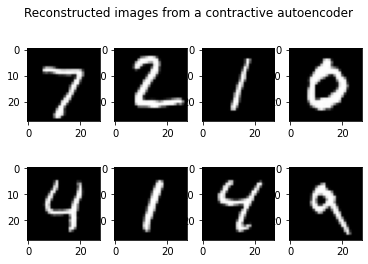

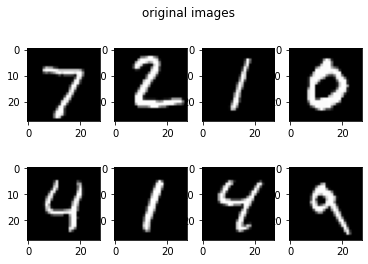

In [40]:
figure, axarr = plt.subplots(2, 4)
figure.suptitle("Reconstructed images from a contractive autoencoder")

for i in range(8):
    contractiveAutoencoderOutput = contractiveAutoencoder.predict(np.expand_dims(x_test[i, :, :, :], axis=0))
    axarr[i//4, i%4].imshow(contractiveAutoencoderOutput[0, :, :, 0],cmap = "gray")
    axarr[i//4, i%4].grid(False)

figure, axarr = plt.subplots(2, 4)
figure.suptitle("original images")

for i in range(8):
   
    axarr[i//4, i%4].imshow(x_test[i, :, :, 0],cmap = "gray")
    axarr[i//4, i%4].grid(False)

### Sparse Autoencoder

In [41]:
input_shape = (28, 28, 1)
batch_size = 64
kernel_size = 3
latent_dim = 16
# latent_dim = 4000
# encoder/decoder number of CNN layers and filters per layer
layer_filters = [32, 64]

# build the autoencoder model
# first build the encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs

# stack of Conv2D(32)-Conv2D(64)
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)
    x = Dropout(0.2)(x)

# shape info needed to build decoder model so we don't do hand computation
# the input to the decoder's first Conv2DTranspose will have this shape
# shape is (7, 7, 64) which can be processed by the decoder back to (28, 28, 1)
shape = K.int_shape(x)

# generate the latent vector
x = Flatten()(x)
x = Dropout(0.2)(x)
latent = Dense(latent_dim, name='latent_vector',activity_regularizer=regularizers.l1(10e-5))(x)

# instantiate encoder model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

# build the decoder model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
# use the shape (7, 7, 64) that was earlier saved
x = Dense(shape[1] * shape[2] * shape[3],activity_regularizer=regularizers.l1(10e-5))(latent_inputs)
# from vector to suitable shape for transposed conv
x = Reshape((shape[1], shape[2], shape[3]))(x)
x = Dropout(0.2)(x)

# stack of Conv2DTranspose(64)-Conv2DTranspose(32)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)
    x = Dropout(0.2)(x)

# reconstruct the denoised input
outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          padding='same',
                          activation='sigmoid',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# autoencoder = encoder + decoder
# instantiate autoencoder model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

# Mean Square Error (MSE) loss function, Adam optimizer
autoencoder.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

# train the autoencoder
train_model=autoencoder.fit(x_train_noisy,
                x_train,
                validation_data=(x_test_noisy, x_test),
                epochs=10,
                batch_size=batch_size)

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 14, 14, 32)        320       
                                                                 
 dropout_6 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_25 (Conv2D)          (None, 7, 7, 64)          18496     
                                                                 
 dropout_7 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 flatten_2 (Flatten)         (None, 3136)              0         
                                                                 
 dropout_8 (Dropout)         (None, 3136)              0   

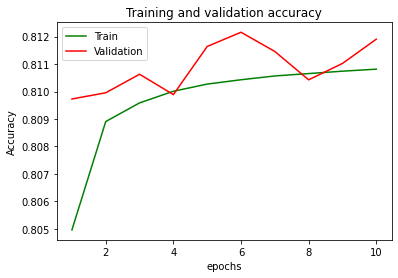

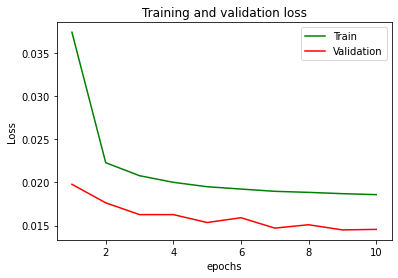

In [42]:
plot_accuracy_and_loss(train_model)

In [43]:
score = autoencoder.evaluate(x_test_noisy, x_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.014561227522790432
Test accuracy: 0.8119050860404968


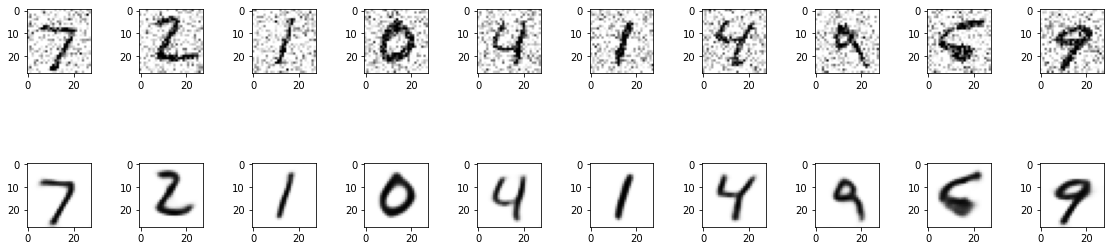

In [44]:
no_noise_img =autoencoder.predict(x_test_noisy)

plt.figure(figsize=(40, 4))
for i in range(10):
    # display original
    ax = plt.subplot(3, 20, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap="binary")
    
    # display reconstructed (after noise removed) image
    ax = plt.subplot(3, 20, 40 +i+ 1)
    plt.imshow(no_noise_img[i].reshape(28, 28), cmap="binary")

plt.show()

### Weight Decay

In [45]:
input_shape = (28, 28, 1)
batch_size = 64
kernel_size = 3
latent_dim = 16
# latent_dim = 4000
# encoder/decoder number of CNN layers and filters per layer
layer_filters = [32, 64]

# build the autoencoder model
# first build the encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs

# stack of Conv2D(32)-Conv2D(64)
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)
    x = Dropout(0.2)(x)

# shape info needed to build decoder model so we don't do hand computation
# the input to the decoder's first Conv2DTranspose will have this shape
# shape is (7, 7, 64) which can be processed by the decoder back to (28, 28, 1)
shape = K.int_shape(x)

# generate the latent vector
x = Flatten()(x)
x = Dropout(0.2)(x)
latent = Dense(latent_dim, name='latent_vector',activity_regularizer=regularizers.l1(10e-5))(x)

# instantiate encoder model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

# build the decoder model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
# use the shape (7, 7, 64) that was earlier saved
x = Dense(shape[1] * shape[2] * shape[3],activity_regularizer=regularizers.l2(0.0001))(latent_inputs)
# from vector to suitable shape for transposed conv
x = Reshape((shape[1], shape[2], shape[3]))(x)
x = Dropout(0.2)(x)

# stack of Conv2DTranspose(64)-Conv2DTranspose(32)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)
    x = Dropout(0.2)(x)

# reconstruct the denoised input
outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          padding='same',
                          activation='sigmoid',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# autoencoder = encoder + decoder
# instantiate autoencoder model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

# Mean Square Error (MSE) loss function, Adam optimizer
autoencoder.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

# train the autoencoder
train_model=autoencoder.fit(x_train_noisy,
                x_train,
                validation_data=(x_test_noisy, x_test),
                epochs=10,
                batch_size=batch_size)

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_26 (Conv2D)          (None, 14, 14, 32)        320       
                                                                 
 dropout_12 (Dropout)        (None, 14, 14, 32)        0         
                                                                 
 conv2d_27 (Conv2D)          (None, 7, 7, 64)          18496     
                                                                 
 dropout_13 (Dropout)        (None, 7, 7, 64)          0         
                                                                 
 flatten_3 (Flatten)         (None, 3136)              0         
                                                                 
 dropout_14 (Dropout)        (None, 3136)              0   

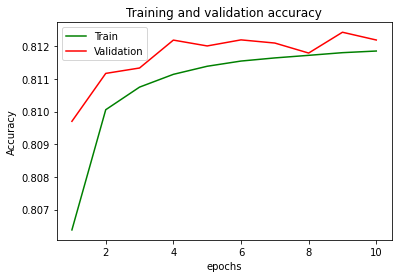

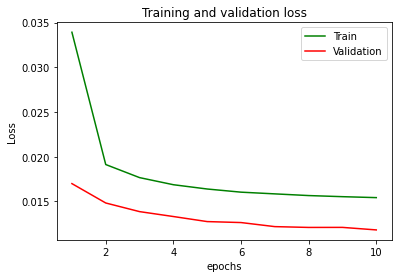

In [46]:
plot_accuracy_and_loss(train_model)

In [47]:
score = autoencoder.evaluate(x_test_noisy, x_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.011816676706075668
Test accuracy: 0.8121944069862366


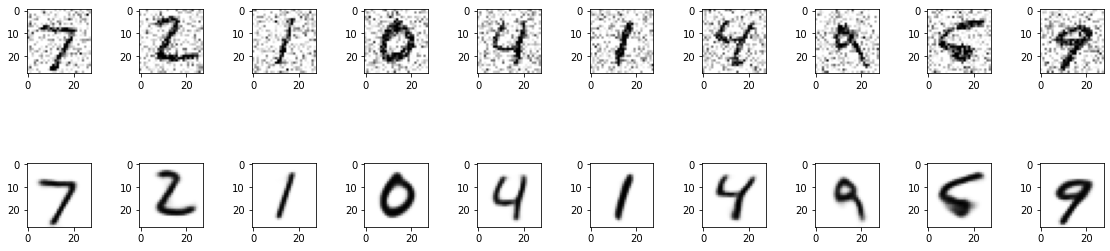

In [48]:
no_noise_img =autoencoder.predict(x_test_noisy)

plt.figure(figsize=(40, 4))
for i in range(10):
    # display original
    ax = plt.subplot(3, 20, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap="binary")
    
    # display reconstructed (after noise removed) image
    ax = plt.subplot(3, 20, 40 +i+ 1)
    plt.imshow(no_noise_img[i].reshape(28, 28), cmap="binary")

plt.show()

### Contractive Autoencoder


In [ ]:
input_shape = (28, 28, 1)
batch_size = 64
kernel_size = 3
latent_dim = 16
# encoder/decoder number of CNN layers and filters per layer
layer_filters = [32, 64]

# build the autoencoder model
# first build the encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs

# stack of Conv2D(32)-Conv2D(64)
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)
    x = Dropout(0.2)(x)

# shape info needed to build decoder model so we don't do hand computation
# the input to the decoder's first Conv2DTranspose will have this shape
# shape is (7, 7, 64) which can be processed by the decoder back to (28, 28, 1)
shape = K.int_shape(x)

# generate the latent vector
x = Flatten()(x)
x = Dropout(0.2)(x)
latent = Dense(latent_dim, name='latent')(x)

# # instantiate encoder model
# encoder = Model(inputs, latent, name='encoder')
# encoder.summary()

# build the decoder model
# latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
# use the shape (7, 7, 64) that was earlier saved
x = Dense(shape[1] * shape[2] * shape[3])(latent)
# from vector to suitable shape for transposed conv
x = Reshape((shape[1], shape[2], shape[3]))(x)
x = Dropout(0.2)(x)

# stack of Conv2DTranspose(64)-Conv2DTranspose(32)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)
    x = Dropout(0.2)(x)

# reconstruct the denoised input
outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          padding='same',
                          activation='sigmoid',
                          name='decoder_output')(x)

# instantiate decoder model
# decoder = Model(latent_inputs, outputs, name='decoder')
# decoder.summary()

# autoencoder = encoder + decoder
# instantiate autoencoder model
autoencoder = Model(inputs, outputs, name='autoencoder')
autoencoder.summary()

In [ ]:
def contractive_loss(y_pred, y_true):
    mse = K.mean(K.square(y_true - y_pred), axis=1)
    W = K.variable(value=autoencoder.get_layer('latent').get_weights()[0])  
    W = K.transpose(W)
    h = model.get_layer('latent').output
    dh = h * (1 - h)
    contractive = lam * K.sum(dh**2 * K.sum(W**2, axis=1), axis=1) #uses the last formula
    return mse + contractive #returns total loss calculated

autoencoder.compile(loss=contractive_loss, optimizer='adam', metrics=['accuracy'])

# train the autoencoder
train_model=autoencoder.fit(x_train_noisy,
                x_train,
                validation_data=(x_test_noisy, x_test),
                epochs=10,
                batch_size=batch_size)

## Inferences and Conclusion : State all the key observations and conclusion

#### Change in accuracy with applying regularizers

* Without regularizer : 0.8001654148101807
* With L1 regularizer : 0.7226935029029846
* With L2 regularizer : 0.8139646649360657
* loss With contractive regularizer : 0.0605868324637413